In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

#### ETF Filter

In [50]:
etf_df = pd.read_csv('ETF_Screen_Information.csv', index_col=0)

etfs = etf_df.ETF_Ticker.unique()
print("number of etfs: {}".format(len(etfs)))

etf_df.Date = pd.to_datetime(etf_df.Date)
etf_df.index = etf_df.Date
etf_df.drop('Date', axis=1, inplace=True)

etf_df.head()

number of etfs: 129


,ETF_Ticker,Average Spread,AUM,Count,Div Yield,Price to Book,Price to Earnings,Total Return,Dollar Volume,ETF Price,ETF_Len
Date,,,,,,,,,,,
2008-01-02,*XCS,NaN,2.792085e+07,217.0,0.039010,1.761031,59.699048,18.435817,NaN,17.467957,4
2008-01-02,*XEG,NaN,5.492800e+08,61.0,0.024876,2.924148,20.516180,26.531370,NaN,22.252901,4
2008-01-02,*XFN,NaN,5.332795e+08,29.0,0.028454,2.183175,13.263941,30.330787,NaN,26.252596,4
2008-01-02,*XGD,NaN,1.125968e+09,37.0,0.005080,2.517170,144.230461,20.947008,NaN,19.519732,4
2008-01-02,*XIC,NaN,4.839745e+08,259.0,0.021631,2.586234,19.966194,27.812710,NaN,22.083185,4


In [51]:
etf_train_df = etf_df[etf_df.index < '2017-01']
etf_test_df = etf_df[etf_df.index >= '2017-01']

In [52]:
etf_train_df

,ETF_Ticker,Average Spread,AUM,Count,Div Yield,Price to Book,Price to Earnings,Total Return,Dollar Volume,ETF Price,ETF_Len
Date,,,,,,,,,,,
2008-01-02,*XCS,NaN,2.792085e+07,217.0,0.039010,1.761031,59.699048,18.435817,NaN,17.467957,4
2008-01-02,*XEG,NaN,5.492800e+08,61.0,0.024876,2.924148,20.516180,26.531370,NaN,22.252901,4
2008-01-02,*XFN,NaN,5.332795e+08,29.0,0.028454,2.183175,13.263941,30.330787,NaN,26.252596,4
2008-01-02,*XGD,NaN,1.125968e+09,37.0,0.005080,2.517170,144.230461,20.947008,NaN,19.519732,4
2008-01-02,*XIC,NaN,4.839745e+08,259.0,0.021631,2.586234,19.966194,27.812710,NaN,22.083185,4
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,THD,0.001687,2.188234e+08,127.0,0.036780,1.704972,17.023808,73.109158,4.319299e+06,58.640000,3
2015-12-31,TOK,0.004715,2.924959e+08,1331.0,0.025310,2.225919,18.165862,62.903881,3.932236e+04,51.760000,3
2015-12-31,TUR,0.001642,3.122362e+08,70.0,0.034893,1.187517,10.329742,42.611211,1.182423e+07,36.360000,3


In [53]:
data_avalibility = pd.concat([etf_train_df.notna().sum(), etf_test_df.notna().sum()],axis=1)
data_avalibility.columns = [['train', 'test']]
data_avalibility

,train,test
ETF_Ticker,327061,193557
Average Spread,80803,180403
AUM,327061,193530
Count,327061,193557
Div Yield,327061,193557
Price to Book,327061,193557
Price to Earnings,327061,193557
Total Return,327061,193557
Dollar Volume,104575,179216
ETF Price,327061,193557


### Pair Filter

In [54]:
etfs = list(etf_train_df['ETF_Ticker'].unique())

In [55]:
def pair_analysis(etf_df, index1, index2, plot=True):

    output = {}

    # calculate spread volatility of 2 indices
    df1 = etf_df[etf_df['ETF_Ticker']==index1]['Total Return'].sort_index()
    df2 = etf_df[etf_df['ETF_Ticker']==index2]['Total Return'].sort_index()
    df12 = pd.concat([df1, df2], axis=1).dropna().sort_index()
    df12.columns = ['Total Return' + ' 1', 'Total Return' + ' 2']
    df12['Spread'] = df12['Total Return 1'] - df12['Total Return 2']
    output['Spread Vol'] = [np.std(df12['Spread'])]

    output = pd.DataFrame.from_dict(output)
    output.index = pd.MultiIndex.from_tuples([(index1, index2)], names=["index 1", "index 2"])
    output

    return output


In [56]:
def pair_analysis(etf_df, index1, index2, plot=True):

    output = {}

    # calculate number of zero crosses
    p1 = np.log(etf_df[etf_df['ETF_Ticker']==index1]['Total Return']).sort_index()
    p2 = np.log(etf_df[etf_df['ETF_Ticker']==index2]['Total Return']).sort_index()

    X = pd.concat([p1, p2], axis=1).dropna().sort_index()
    X.replace(to_replace=0, method='ffill')
    X.columns = ['Price 1', 'Price 2']
    y = X['Price 1']
    X = X.drop('Price 1',axis=1)

    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    output['const'] = [np.round(result.params[0], 4)]
    output['beta'] = [np.round(result.params[1], 4)]

    if plot:
        plt.rcParams["figure.figsize"] = (20,5)

        fig, axs = plt.subplots(1, 2)

        axs[0].plot(np.exp(X @ result.params))
        axs[0].plot(np.exp(y))
        axs[0].set_title("Scaled Price: {} vs {}".format(index2, index1))
        axs[0].legend([index2, index1])

        axs[1].plot(result.resid)
        axs[1].hlines(0,result.resid.index.min(), result.resid.index.max(), colors='r')
        axs[1].set_title("Residues: {} vs {}".format(index2, index1))

        plt.show()

    trade_period = len(result.resid)
    n_zero_cross = np.nansum(result.resid.sort_index().rolling(2).apply(lambda x: 1 if np.sign(x[1]) != np.sign(x[0]) else 0))
    output['trade_period'] = [trade_period]
    output['n_zero_cross'] = [int(n_zero_cross)]

    # average deivation difference
    output['avg_distance'] = [np.mean(np.abs(result.resid))]

    # calculate cointergration
    coint_test = adfuller(result.resid.sort_index())
    output['coint'] = [1 if coint_test[1] < 0.05 else 0]
    output['coint_p_value'] = [coint_test[1]]

    # calculate liquidity measure: market effective coefficient
    p1 = p1.dropna().sort_index()
    p2 = p2.dropna().sort_index()
    def mrk_eff_cal(p1):
        d_ret = p1 - p1.shift(1)
        m_ret = p1 - p1.shift(20)
        mrk_eff_coef = np.var(m_ret.dropna())/(20*np.var(d_ret.dropna()))
        return mrk_eff_coef
    output['mrk_eff_coef_1'] = [np.round(mrk_eff_cal(p1), 4)]
    output['mrk_eff_coef_2'] = [np.round(mrk_eff_cal(p2), 4)]

    # calculate similarity of 2 indices
    params = ['Price to Book', 'Price to Earnings', 'Div Yield']
    if plot:
        fig, ax = plt.subplots(1,3)

    for i,p in enumerate(params):
        df1 = etf_df[etf_df['ETF_Ticker']==index1][p].resample('M').mean().sort_index()
        df2 = etf_df[etf_df['ETF_Ticker']==index2][p].resample('M').mean().sort_index()
        df12 = pd.concat([df1, df2], axis=1).dropna().sort_index()
        df12.columns = [p + ' 1', p + ' 2']
        output[p + ' 1'] = [np.round(np.mean(df12[p + ' 1']),4)]
        output[p + ' 2'] = [np.round(np.mean(df12[p + ' 2']),4)]
        output[p + ' Corr'] = [np.round(df12[p + ' 1'].corr(df12[p + ' 2']),4)]

        if plot:
            ax2 = ax[i].twinx()
            ax[i].plot(df12[p + ' 1'], color='green')
            ax2.plot(df12[p + ' 2'], color='blue')
            ax[i].set_xticklabels(df12.index.date, rotation=45)
            ax[i].set_title("{} vs {} {} Ratio w Corr: {}".format(index1, index2, p, output[p + ' Corr'][0]))
    if plot:
        plt.show()

    # calculate spread volatility of 2 indices
    df1 = etf_df[etf_df['ETF_Ticker']==index1]['Total Return'].sort_index()
    df2 = etf_df[etf_df['ETF_Ticker']==index2]['Total Return'].sort_index()
    df12 = pd.concat([df1, df2], axis=1).dropna().sort_index()
    df12.columns = ['Total Return' + ' 1', 'Total Return' + ' 2']
    df12['Spread'] = df12['Total Return 1'] - df12['Total Return 2']
    output['Spread Vol'] = [np.std(df12['Spread'])]

    # calculate mean dollar volume, aum
    params = ['AUM', 'Dollar Volume']
    for p in params:
        df1 = etf_df[etf_df['ETF_Ticker']==index1][p].sort_index()
        df2 = etf_df[etf_df['ETF_Ticker']==index2][p].sort_index()
        df12 = pd.concat([df1, df2], axis=1).dropna().sort_index()
        df12.columns = [p + ' 1', p + ' 2']

        output[p + ' 1'] = [np.round(df12[p+' 1'].mean(),4)]
        output[p + ' 2'] = [df12[p+' 2'].mean()]

        if df12[p+' 1'].mean() == 0:
            output[p + ' ratio'] = [index1 + " 0"]
        elif df12[p+' 2'].mean() == 0:
            output[p + ' ratio'] = [index2 + " 0"]
        else:
            volume_ratio = df12[p+' 1'].mean()/df12[p+' 2'].mean()
            output[p + ' ratio'] = [np.round(volume_ratio, 4)]

    output = pd.DataFrame.from_dict(output)
    output.index = pd.MultiIndex.from_tuples([(index1, index2)], names=["index 1", "index 2"])
    output

    return output


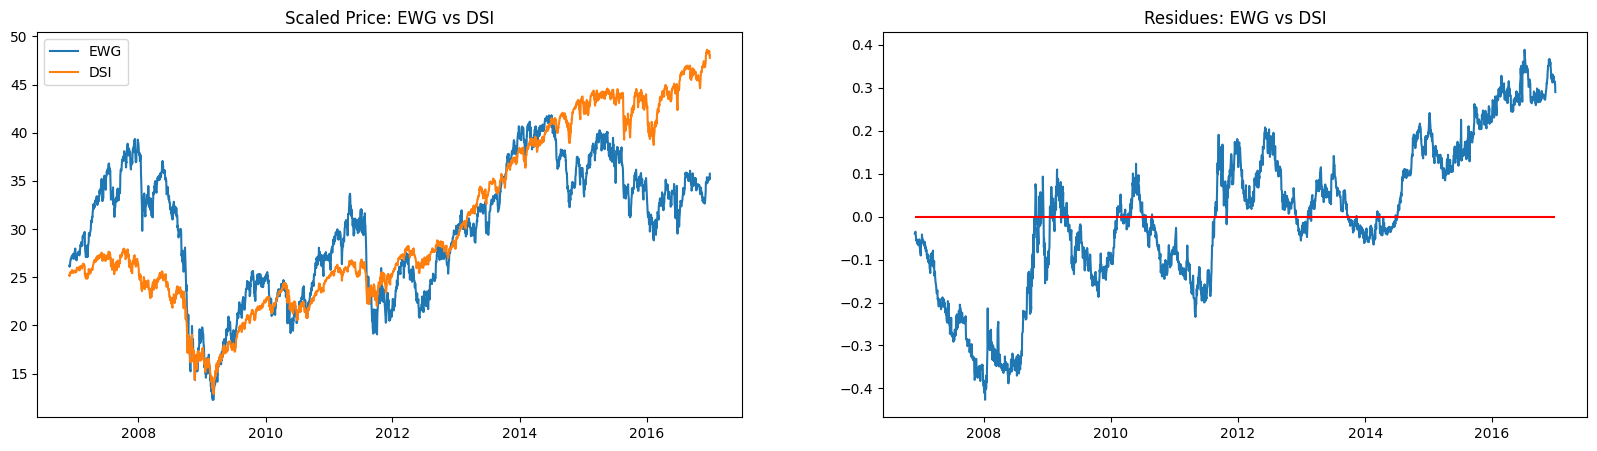

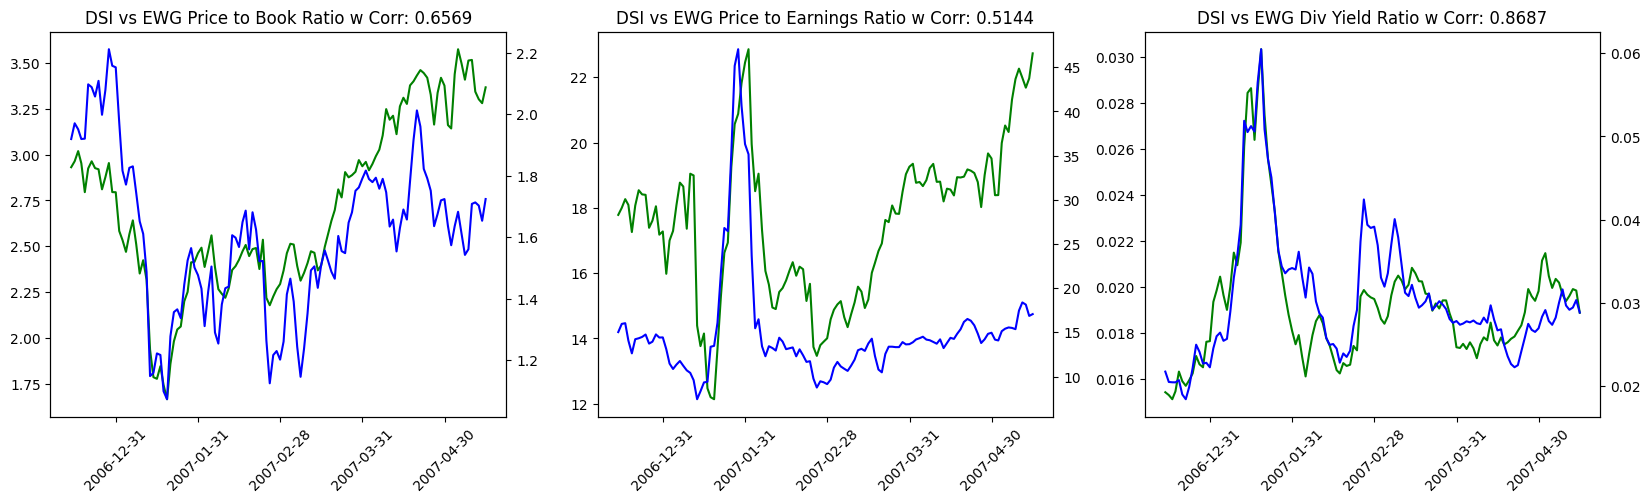

,,const,beta,trade_period,n_zero_cross,avg_distance,coint,coint_p_value,mrk_eff_coef_1,mrk_eff_coef_2,Price to Book 1,...,Div Yield 1,Div Yield 2,Div Yield Corr,Spread Vol,AUM 1,AUM 2,AUM ratio,Dollar Volume 1,Dollar Volume 2,Dollar Volume ratio
index 1,index 2,,,,,,,,,,,,,,,,,,,,,
DSI,EWG,-0.8378,1.1754,2539,83,0.139581,0,0.686096,0.6786,0.8823,2.7146,...,0.0192,0.0306,0.8687,5.819462,2.169104e+08,3.081537e+09,0.0704,1.945034e+06,1.299428e+08,0.015


In [57]:
index1 = etfs[10]
index2 = etfs[20]
output = pair_analysis(etf_train_df, index1, index2, plot=True)
output

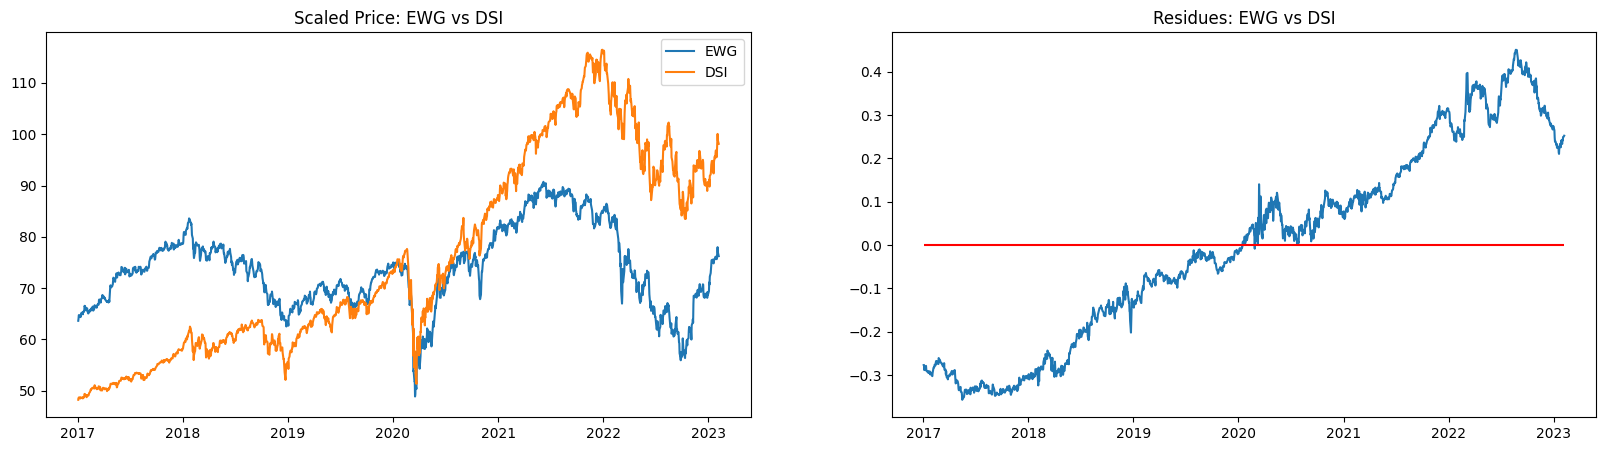

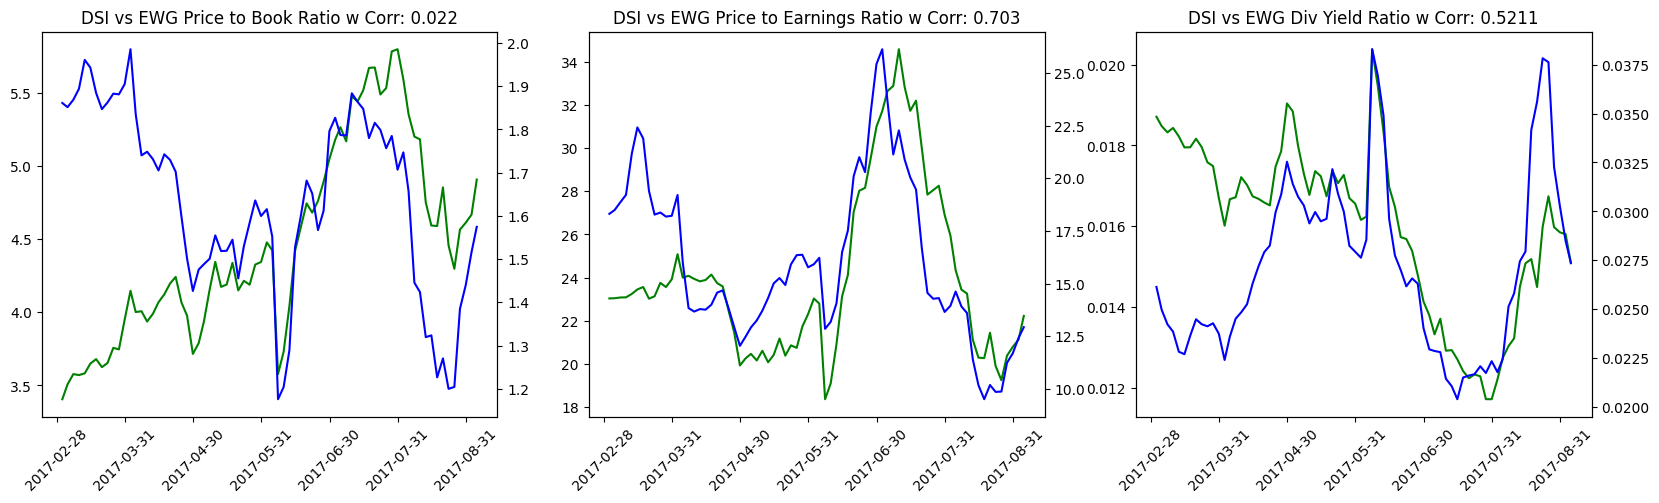

,,const,beta,trade_period,n_zero_cross,avg_distance,coint,coint_p_value,mrk_eff_coef_1,mrk_eff_coef_2,Price to Book 1,...,Div Yield 1,Div Yield 2,Div Yield Corr,Spread Vol,AUM 1,AUM 2,AUM ratio,Dollar Volume 1,Dollar Volume 2,Dollar Volume ratio
index 1,index 2,,,,,,,,,,,,,,,,,,,,,
DSI,EWG,0.9594,0.8519,1534,3,0.193406,0,0.785865,0.81,1.1959,4.4515,...,0.016,0.0271,0.5211,17.284222,2.103884e+09,2.849383e+09,0.7384,1.056081e+07,1.156071e+08,0.0914


In [58]:
# index1 = etfs[100]
# index2 = etfs[200]
output = pair_analysis(etf_test_df, index1, index2, plot=True)
output

In [59]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()

In [60]:
num_cores

4

In [61]:
def calculate_pair_analysis(i, df, etfs):
    output_df = pd.DataFrame()    
    for j in range(i+1, len(etfs)):
        try:
            output = pair_analysis(df, etfs[i], etfs[j], plot=False)
            output_df = pd.concat([output_df, output], axis=0)
        except Exception as e:
            print(etfs[i], etfs[j])
            print(e)
    return output_df

In [72]:
etfs = list(etf_test_df['ETF_Ticker'].unique())

In [73]:
processed_list = Parallel(n_jobs=num_cores)(delayed(calculate_pair_analysis)(i, etf_test_df, etfs) for i in range(len(etfs)))

/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site

In [74]:
output_all = pd.concat(processed_list)

In [75]:
output_all['percent_zero_cross'] = output_all['n_zero_cross']/output_all['trade_period']

In [76]:
output_all.to_csv("Pairs_Screen_Measures_test_2017.csv")

In [77]:
output_all

const    beta  trade_period  n_zero_cross  avg_distance  \
index 1 index 2                                                             
*XCS    *XEG     1.6952  0.4752           962            49      0.041938   
        *XEI     0.0616  0.8870          1523            25      0.072854   
        *XFN    -0.6218  0.9060          1523            47      0.063633   
        *XGD     2.0839  0.3395          1523            22      0.128717   
        *XIC    -0.4413  0.9372          1523            41      0.072235   
...                 ...     ...           ...           ...           ...   
TUR     WPS      5.2041 -0.3999          1534            39      0.185868   
        IYZ      3.6881 -0.0558           885            49      0.110771   
WOOD    WPS      0.0302  1.0763          1534            21      0.131269   
        IYZ     -1.0519  1.4145           885            19      0.103547   
WPS     IYZ      1.2332  0.7498           885            25      0.049926   

                 coint  coint_p_value  mrk_eff_coef_1  mrk_eff_coef_2  \
index 1 index 2                                                         
*XCS    *XEG         0       0.068413          1.5616          1.1657   
        *XEI         0       0.225208          1.5616          1.2971   
        *XFN         1       0.031384          1.5616          1.1779   
        *XGD         0       0.273197          1.5616          0.9018   
        *XIC         0       0.148224          1.5616          1.2437   
...                ...            ...             ...             ...   
TUR     WPS          0       0.240624          0.9889          1.7205   
        IYZ          0       0.054666          0.9889          0.5827   
WOOD    WPS          0       0.814989          1.2178          1.7205   
        IYZ          1       0.001414          1.2178          0.5827   
WPS     IYZ          0       0.147760          1.7205          0.5827   

                 Price to Book 1  ...  Div Yield 2  Div Yield Corr  \
index 1 index 2                   ...                                
*XCS    *XEG              1.2105  ...       0.0259          0.7713   
        *XEI              1.2434  ...       0.0471          0.8893   
        *XFN              1.2434  ...       0.0367          0.7309   
        *XGD              1.2434  ...       0.0113         -0.5966   
        *XIC              1.2434  ...       0.0281          0.8415   
...                          ...  ...          ...             ...   
TUR     WPS               1.2004  ...       0.0372          0.1331   
        IYZ               1.0469  ...       0.0295         -0.4571   
WOOD    WPS               1.6490  ...       0.0372          0.6670   
        IYZ               1.6521  ...       0.0295          0.1698   
WPS     IYZ               0.9940  ...       0.0295          0.5634   

                 Spread Vol         AUM 1         AUM 2  AUM ratio  \
index 1 index 2                                                      
*XCS    *XEG       1.735631  1.271003e+08  1.142234e+09     0.1113   
        *XEI       2.661784  1.343044e+08  8.099331e+08     0.1658   
        *XFN       7.432058  1.343044e+08  1.175467e+09     0.1143   
        *XGD       3.740993  1.343044e+08  9.732385e+08     0.1380   
        *XIC       4.125838  1.343044e+08  6.241208e+09     0.0215   
...                     ...           ...           ...        ...   
TUR     WPS       11.757491  3.284129e+08  1.101575e+08     2.9813   
        IYZ        7.018153  3.232617e+08  4.179161e+08     0.7735   
WOOD    WPS       13.843885  2.982085e+08  1.101575e+08     2.7071   
        IYZ       12.798044  3.069222e+08  4.179161e+08     0.7344   
WPS     IYZ        3.775606  1.157851e+08  4.179161e+08     0.2771   

                 Dollar Volume 1  Dollar Volume 2  Dollar Volume ratio  \
index 1 index 2                                                          
*XCS    *XEG                 NaN              NaN                  NaN   
        *XEI          

In [78]:
# spread data and dollar volume data is missing for some pairs
output_all.notna().sum()

const                     8256
beta                      8256
trade_period              8256
n_zero_cross              8256
avg_distance              8256
coint                     8256
coint_p_value             8256
mrk_eff_coef_1            8256
mrk_eff_coef_2            8256
Price to Book 1           8256
Price to Book 2           8256
Price to Book Corr        8256
Price to Earnings 1       8256
Price to Earnings 2       8256
Price to Earnings Corr    8256
Div Yield 1               8256
Div Yield 2               8256
Div Yield Corr            8256
Spread Vol                8256
AUM 1                     8256
AUM 2                     8256
AUM ratio                 8256
Dollar Volume 1           7137
Dollar Volume 2           7137
Dollar Volume ratio       7137
percent_zero_cross        8256
dtype: int64

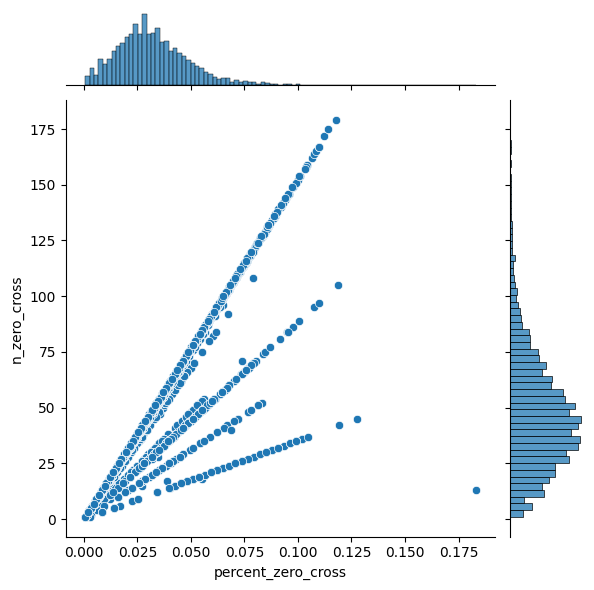

In [79]:
import seaborn as sns
sns.jointplot(data=output_all, x="percent_zero_cross", y="n_zero_cross")
plt.show()

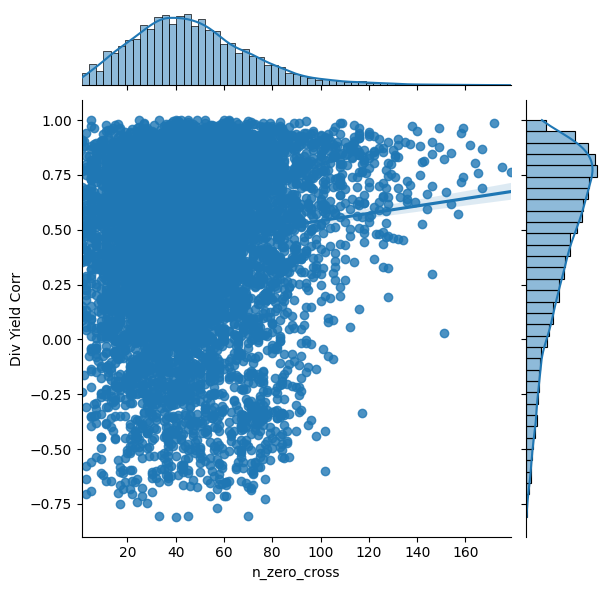

In [80]:
sns.jointplot(data=output_all, x="n_zero_cross", y="Div Yield Corr", kind='reg')
plt.show()

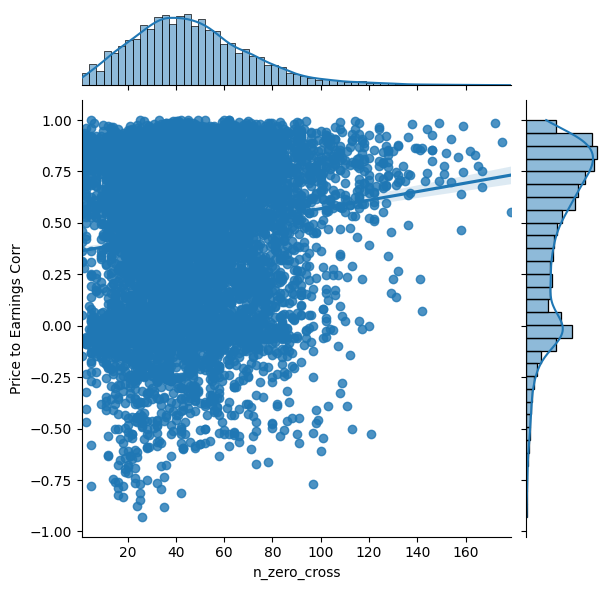

In [81]:
sns.jointplot(data=output_all, x="n_zero_cross", y="Price to Earnings Corr", kind='reg')
plt.show()

In [33]:
output_all[(output_all['Price to Earnings Corr']<0) & (output_all['coint']==1)]

const    beta  trade_period  n_zero_cross  avg_distance  \
index 1 index 2                                                             
*XCS    *XFN    -1.0432  1.0067          1272            47      0.054963   
        050424  -0.9731  1.3801          1272            44      0.118710   
        084710  -2.3444  1.2433          1272            78      0.084911   
        314420   0.0577  0.7754          1272            72      0.090736   
        594604  -3.0765  1.4512          1272            88      0.088356   
...                 ...     ...           ...           ...           ...   
REM     SOXX     4.9028  0.0184          1283            23      0.132418   
        SUSA     4.6169  0.0869          1283            25      0.133658   
        THD     -0.4604  1.1631          1283            64      0.095423   
        TOK      4.0754  0.2016          1283            23      0.134189   
        TUR      4.6836  0.0934          1283            28      0.135313   

                 coint  coint_p_value  mrk_eff_coef_1  mrk_eff_coef_2  \
index 1 index 2                                                         
*XCS    *XFN         1       0.032908          1.5935          1.1784   
        050424       1       0.003786          1.5935          1.1275   
        084710       1       0.000150          1.5935          1.1224   
        314420       1       0.001016          1.5935          0.8257   
        594604       1       0.001240          1.5935          1.0573   
...                ...            ...             ...             ...   
REM     SOXX         1       0.010220          1.5037          0.6434   
        SUSA         1       0.011678          1.5037          0.8263   
        THD          1       0.010521          1.5037          1.3885   
        TOK          1       0.015454          1.5037          1.0186   
        TUR          1       0.012533          1.5037          0.9906   

                 Price to Book 1  ...  Div Yield 2  Div Yield Corr  \
index 1 index 2                   ...                                
*XCS    *XFN              1.2267  ...       0.0375          0.7903   
        050424            1.2267  ...       0.0369          0.8002   
        084710            1.2267  ...       0.0301          0.7549   
        314420            1.2267  ...       0.0168          0.7719   
        594604            1.2267  ...       0.0329          0.7097   
...                          ...  ...          ...             ...   
REM     SOXX              0.8776  ...       0.0145          0.5340   
        SUSA              0.8776  ...       0.0165          0.5773   
        THD               0.8776  ...       0.0303          0.7147   
        TOK               0.8776  ...       0.0205          0.5751   
        TUR               0.8776  ...       0.0332         -0.0020   

                 Spread Vol         AUM 1         AUM 2  AUM ratio  \
index 1 index 2                                                      
*XCS    *XFN       7.222383  1.345686e+08  1.192535e+09     0.1128   
        050424     3.143768  1.345686e+08  7.973800e+09     0.0169   
        084710     6.756343  1.345686e+08  4.172922e+09     0.0322   
        314420     6.415465  1.345686e+08  1.060336e+10     0.0127   
        594604     4.516378  1.345686e+08  6.261055e+08     0.2149   
...                     ...           ...           ...        ...   
REM     SOXX     137.350456  1.141744e+09  4.159091e+09     0.2745   
        SUSA      30.013347  1.141744e+09  2.088568e+09     0.5467   
        THD       18.476920  1.141744e+09  4.187209e+08     2.7267   
        TOK       27.221443  1.141744e+09  2.085327e+08     5.4751   
        TUR       24.569768  1.141744e+09  3.161996e+08     3.6108   

                 Dollar Volume 1  Dollar Volume 2  Dollar Volume ratio  \
index 1 index 2                                                          
*XCS    *XFN                 NaN              NaN                  NaN   
        050424        

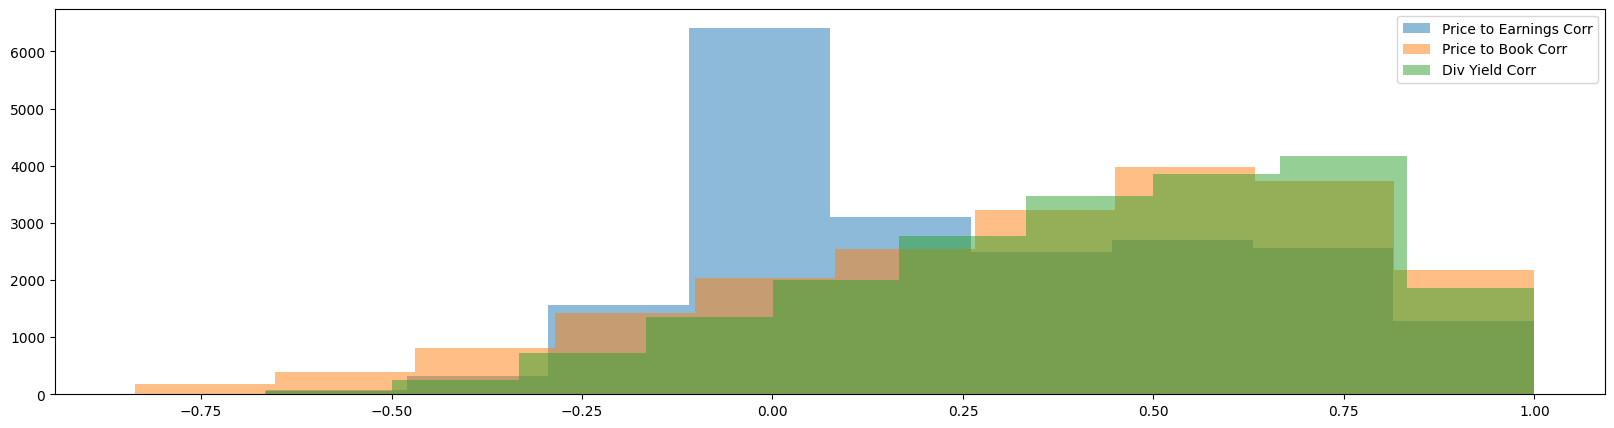

In [30]:
plt.hist(output_all['Price to Earnings Corr'], alpha=0.5)
plt.hist(output_all['Price to Book Corr'], alpha=0.5)
plt.hist(output_all['Div Yield Corr'], alpha=0.5)
plt.legend(['Price to Earnings Corr', 'Price to Book Corr', 'Div Yield Corr'])
plt.show()

In [161]:
def cal_features(df, index1, index2):
    p1 = df[df['ETF_Ticker']==index1]['Total Return']
    p2 = df[df['ETF_Ticker']==index2]['Total Return']

    price_df = pd.concat([p1,p2],axis=1).dropna().sort_index()
    price_df.columns = [['Total Return 1', 'Total Return 2']]

    y = price_df['Total Return 1']
    X = price_df.drop('Total Return 1',axis=1)

    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    result.resid

    days_s_cross = result.resid.sort_index().rolling(2).apply(lambda x: 0 if np.sign(x[1]) != np.sign(x[0]) else 1).fillna(0)
    no_reset_arr = days_s_cross.cumsum()
    reset_arr = days_s_cross == 0
    excess = np.maximum.accumulate(reset_arr * no_reset_arr)
    days_s_cross = no_reset_arr - excess 

    n_zero_cross = result.resid.sort_index().rolling(2).apply(lambda x: 1 if np.sign(x[1]) != np.sign(x[0]) else 0)
    n_zero_cross = n_zero_cross.fillna(0).cumsum()
    price_df['zero_cross'] = n_zero_cross
    price_df['days_s_cross'] = days_s_cross

    price_df.insert(0, 'Ticker Pair', index1+'_'+index2, True)

    return price_df

In [162]:
cal_features(etf_train_df, etfs[10], etfs[11])

,Ticker Pair,Total Return 1,Total Return 2,zero_cross,days_s_cross
Date,,,,,
2008-03-31,ACWI_ACWX,49.560000,50.240000,0.0,0.0
2008-04-01,ACWI_ACWX,50.670000,50.800000,0.0,1.0
2008-04-02,ACWI_ACWX,51.150000,51.710000,0.0,2.0
2008-04-03,ACWI_ACWX,51.300000,51.910000,0.0,3.0
2008-04-04,ACWI_ACWX,51.530000,52.250000,0.0,4.0
...,...,...,...,...,...
2016-12-23,ACWI_ACWX,70.753888,49.866609,59.0,578.0
2016-12-27,ACWI_ACWX,70.817462,49.840561,59.0,579.0
2016-12-28,ACWI_ACWX,70.533343,49.891286,59.0,580.0
